In [2]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'


2.13.0


In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
df=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv")
df.set_index('Date', inplace=True)
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [4]:
df.describe()

,Births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


In [5]:
from datetime import datetime, timedelta

# Load the dataset from the URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
df = pd.read_csv(url, header=0, parse_dates=[0], index_col=0)

# Display the first few rows of the dataset
print(df.head())

# Get the most recent observation
last_observation = df.iloc[-1]

# Forecast using persistence forecasting
forecast = last_observation['Births']

print(f"The persistence forecast for the next period is: {forecast}")

            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44
The persistence forecast for the next period is: 50


In [6]:
# Load the dataset from the URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
df = pd.read_csv(url, header=0, parse_dates=[0], index_col=0)

# Extract the month and day as a new column
df['Month'] = df.index.month
df['Day'] = df.index.day

# Define a function to calculate the seasonal naive forecast
def seasonal_naive_forecast(df, month, day):
    last_year_data = df[(df['Month'] == month) & (df['Day'] == day)]['Births']
    forecast = last_year_data.iloc[-1] if not last_year_data.empty else None
    return forecast

# Apply the seasonal naive forecast for each day in the dataset
forecasts = []
for _, row in df.iterrows():
    forecast = seasonal_naive_forecast(df, row['Month'], row['Day'])
    forecasts.append(forecast)

# Add the forecasts as a new column in the DataFrame
df['SeasonalNaiveForecast'] = forecasts

# Display the resulting DataFrame with the forecasts
print(df)

            Births  Month  Day  SeasonalNaiveForecast
Date                                                 
1959-01-01      35      1    1                     35
1959-01-02      32      1    2                     32
1959-01-03      30      1    3                     30
1959-01-04      31      1    4                     31
1959-01-05      44      1    5                     44
...            ...    ...  ...                    ...
1959-12-27      37     12   27                     37
1959-12-28      52     12   28                     52
1959-12-29      48     12   29                     48
1959-12-30      55     12   30                     55
1959-12-31      50     12   31                     50

[365 rows x 4 columns]


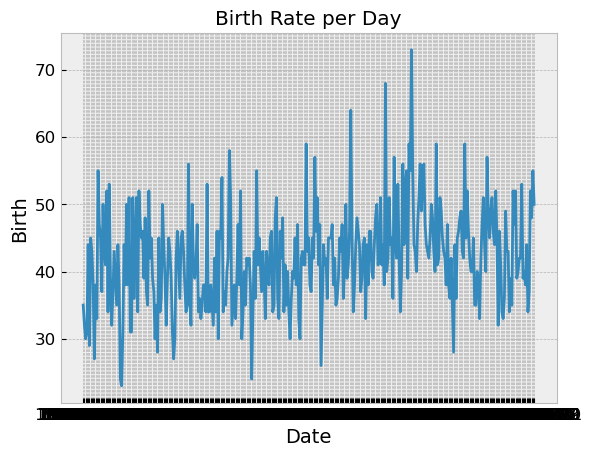

In [5]:
#plot graph
plt.title("Birth Rate per Day")
plt.xlabel("Date")
plt.ylabel("Birth")
plt.plot(df)

NameError: name 'mm' is not defined

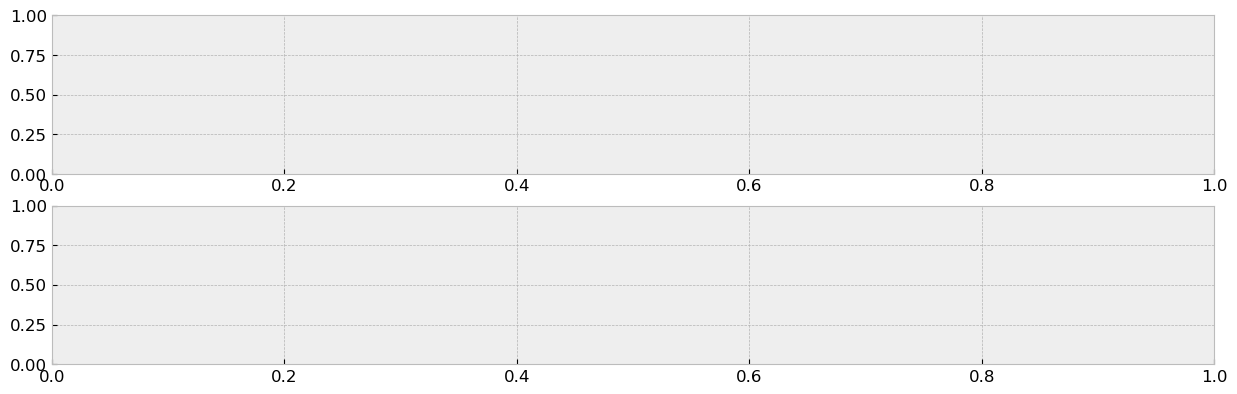

In [6]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)

mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)




mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(df.Births))]
X = np.reshape(X, (len(X), 1))
y = df.Births.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

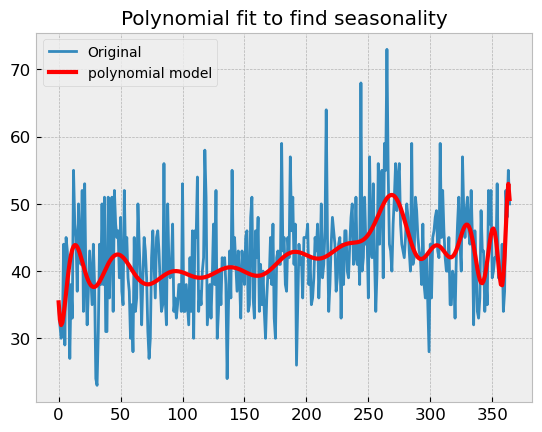

In [7]:
# Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = df.Births.values
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

Text(0.5, 1.0, 'Mean over time')

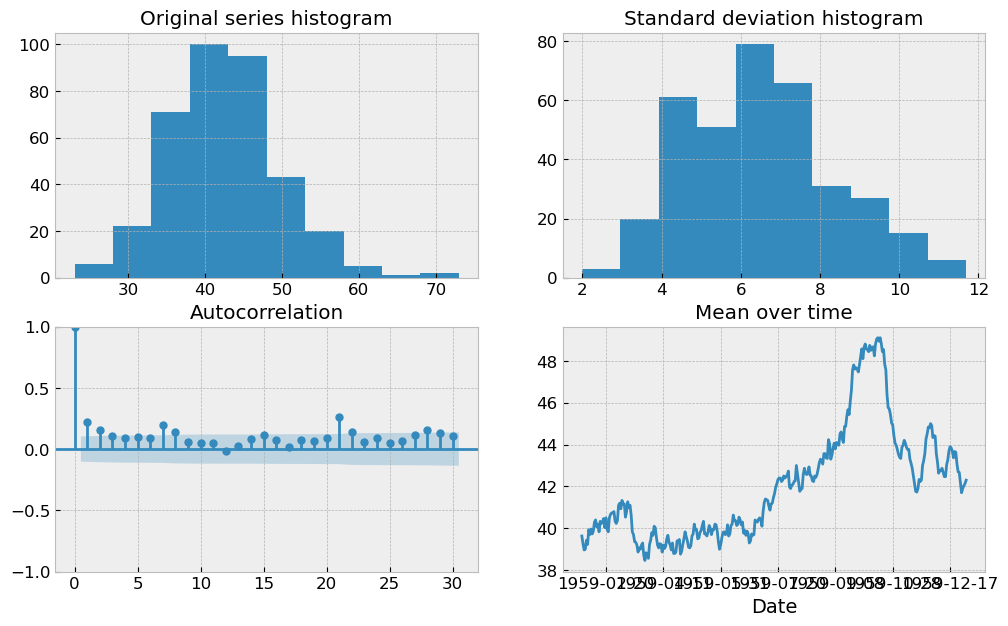

In [8]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

df.Births.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = df.Births.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = df.Births.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

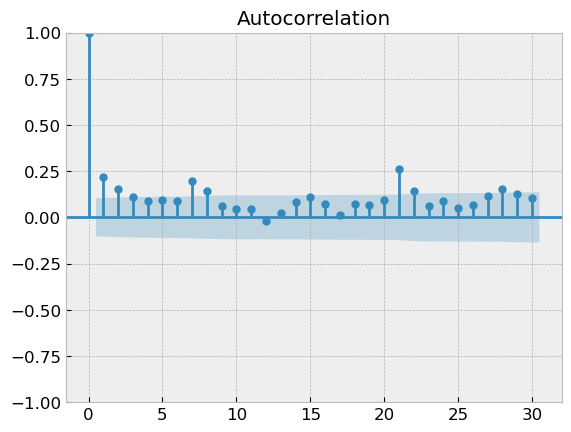

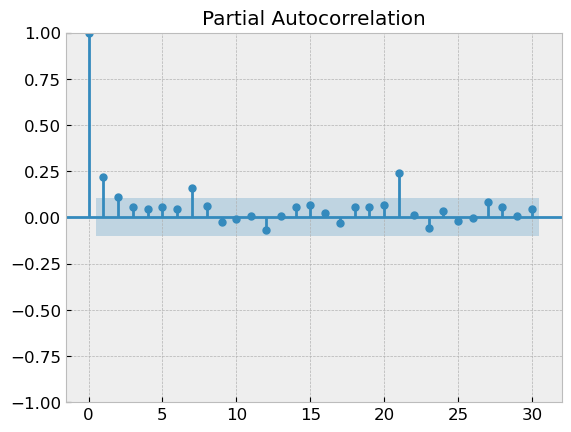

In [9]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

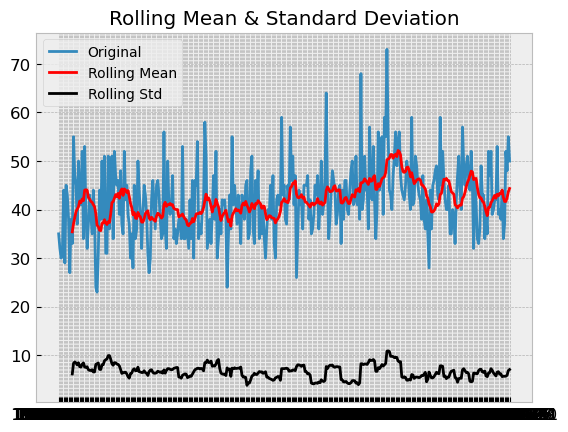

In [10]:
# Determing rolling statistics
rolmean = df.Births.rolling(window=12).mean()
rolstd = df.Births.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(df.Births, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [11]:
#Augmented Dickey-Fuller test
X = df.Births.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.808291
p-value: 0.000052
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


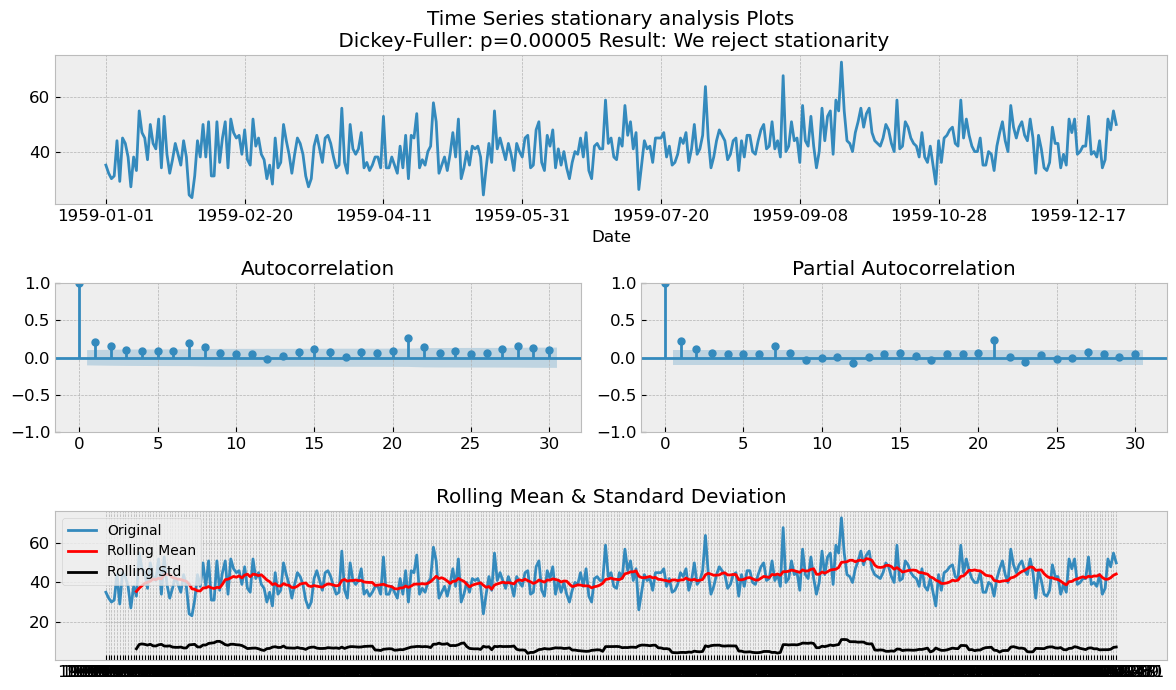

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = df.Births.rolling(window=12).mean()
        rolstd = df.Births.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(df.Births, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(df.Births, lags=30)

Text(0.5, 1.0, 'Log scale transformation into original series')

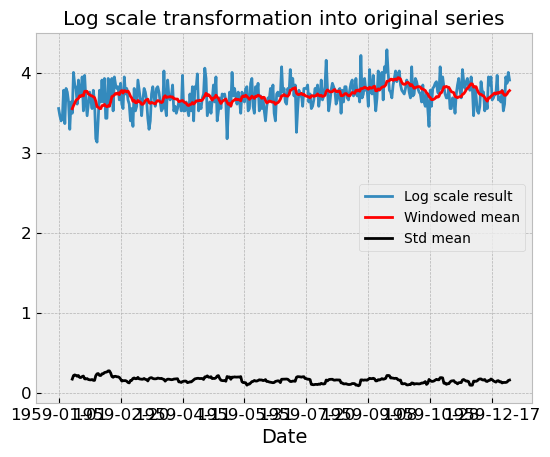

In [13]:
#Log scale transformation
ts_log = np.log(df.Births)
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

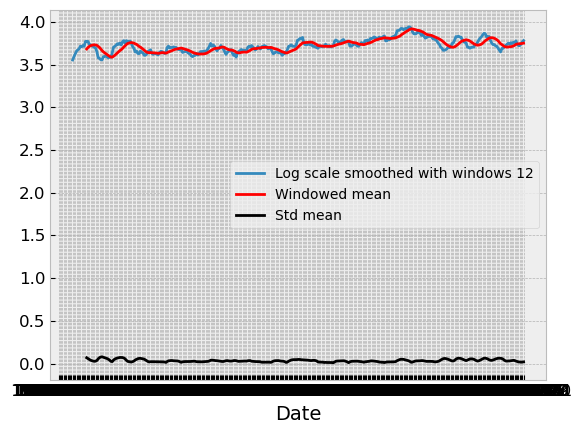

In [14]:
#Smoothing
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()

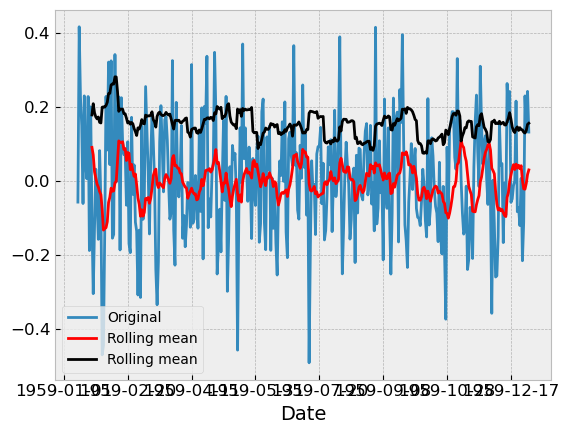

In [15]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(
    color='red', label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(
    color='black', label="Rolling mean")
plt.legend(loc='best')

In [16]:
#Prepare data before modeling
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

split_date = '1959-06-01'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")


152 days of training data 
 213 days of testing data 


Root Mean Squared Error (RMSE): 7.54


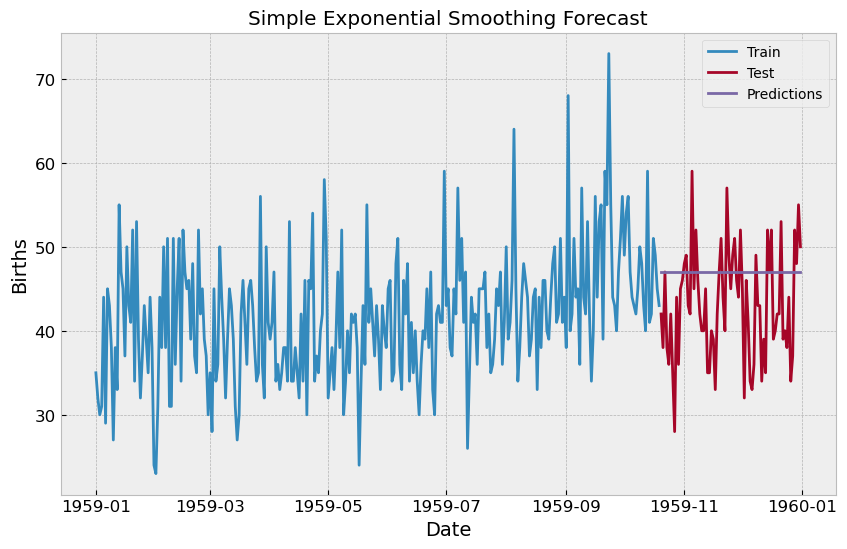

In [19]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tools.eval_measures import rmse

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url)

# Convert the 'Date' column to a datetime object and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Create a SimpleExpSmoothing model and fit it to the training data
model = SimpleExpSmoothing(train['Births'])
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate RMSE
error = rmse(test['Births'], predictions)
print(f"Root Mean Squared Error (RMSE): {error:.2f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Births'], label='Train')
plt.plot(test.index, test['Births'], label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Births')
plt.show()


Root Mean Squared Error (RMSE): 7.54


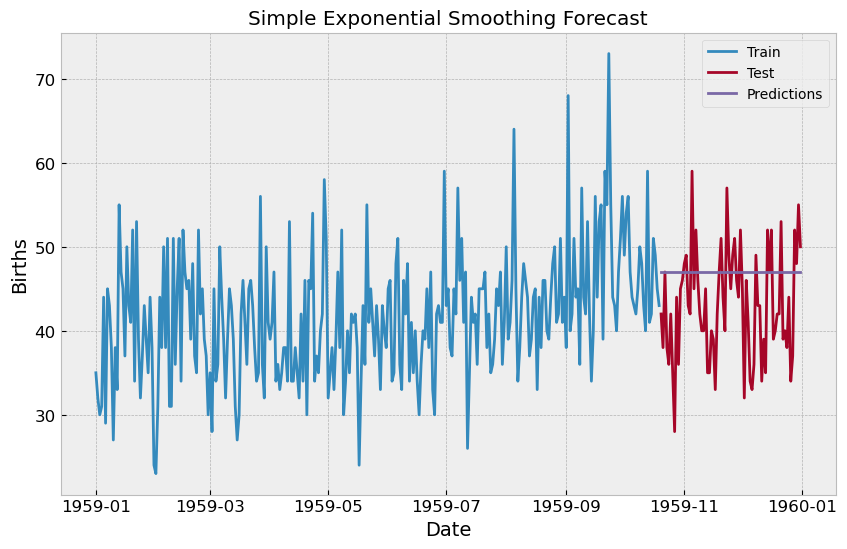

In [18]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tools.eval_measures import rmse

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url)

# Convert the 'Date' column to a datetime object and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Create a SimpleExpSmoothing model and fit it to the training data
model = SimpleExpSmoothing(train['Births'])
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate RMSE
error = rmse(test['Births'], predictions)
print(f"Root Mean Squared Error (RMSE): {error:.2f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Births'], label='Train')
plt.plot(test.index, test['Births'], label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Births')
plt.show()



Root Mean Squared Error (RMSE): 11.17


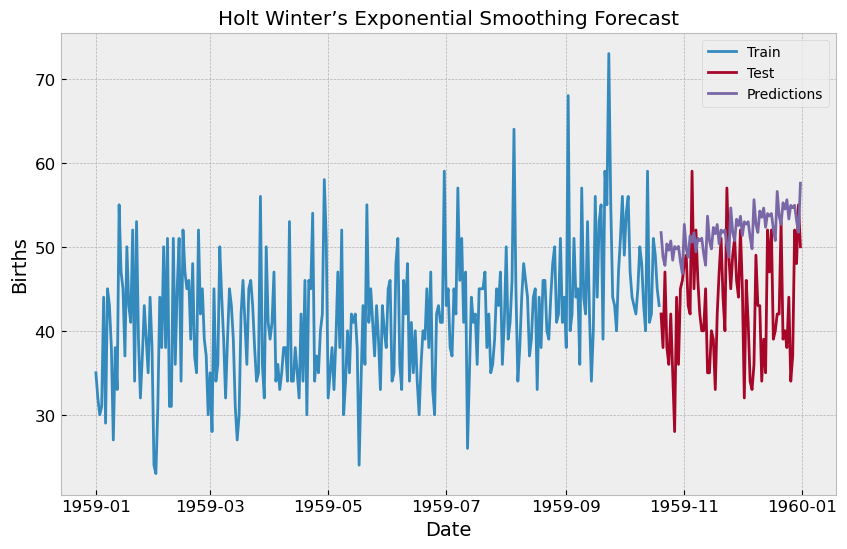

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import rmse

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url)

# Convert the 'Date' column to a datetime object and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Create an ExponentialSmoothing model and fit it to the training data
model = ExponentialSmoothing(train['Births'], trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate RMSE
error = rmse(test['Births'], predictions)
print(f"Root Mean Squared Error (RMSE): {error:.2f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Births'], label='Train')
plt.plot(test.index, test['Births'], label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.title("Holt Winter’s Exponential Smoothing Forecast")
plt.xlabel('Date')
plt.ylabel('Births')
plt.show()


Root Mean Squared Error (RMSE): 9.75


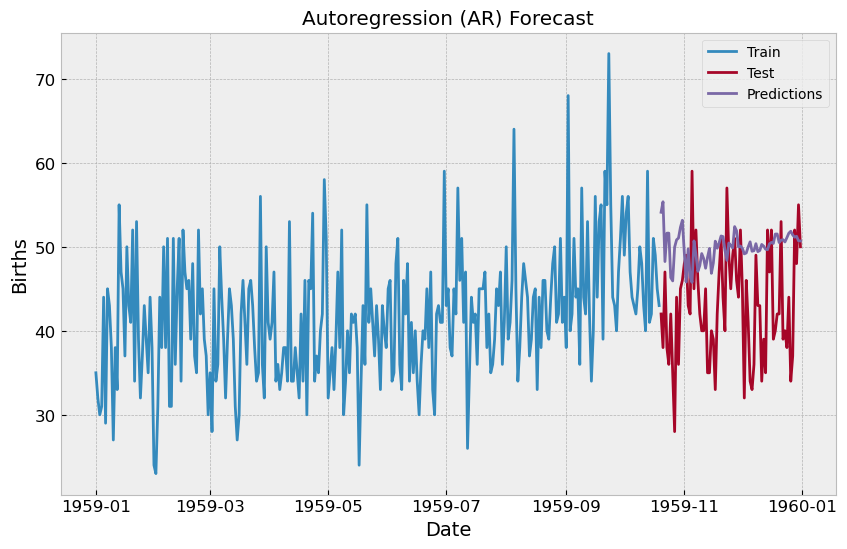

In [21]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url)

# Convert the 'Date' column to a datetime object and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Create an AutoReg model and fit it to the training data
lag = 30  # Number of lag observations to include in the model
model = AutoReg(train['Births'], lags=lag)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Calculate RMSE
error = rmse(test['Births'], predictions)
print(f"Root Mean Squared Error (RMSE): {error:.2f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Births'], label='Train')
plt.plot(test.index, test['Births'], label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.title("Autoregression (AR) Forecast")
plt.xlabel('Date')
plt.ylabel('Births')
plt.show()


In [29]:
pip install pmdarima

                                              0.0/566.2 kB ? eta -:--:--
     -----------                            174.1/566.2 kB 3.6 MB/s eta 0:00:01
     --------------------------------       481.3/566.2 kB 6.0 MB/s eta 0:00:01
     -------------------------------------- 566.2/566.2 kB 5.1 MB/s eta 0:00:00
                                              0.0/2.8 MB ? eta -:--:--
     -----                                    0.4/2.8 MB 12.9 MB/s eta 0:00:01
     -----------                              0.8/2.8 MB 10.2 MB/s eta 0:00:01
     ----------------                         1.2/2.8 MB 9.2 MB/s eta 0:00:01
     -----------------------                  1.6/2.8 MB 9.3 MB/s eta 0:00:01
     ----------------------------             2.0/2.8 MB 9.1 MB/s eta 0:00:01
     ---------------------------------        2.3/2.8 MB 8.6 MB/s eta 0:00:01
     -------------------------------------    2.6/2.8 MB 8.2 MB/s eta 0:00:01
     ---------------------------------------- 2.8/2.8 MB 7.7 MB/s et

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


Root Mean Squared Error (RMSE): 6.58


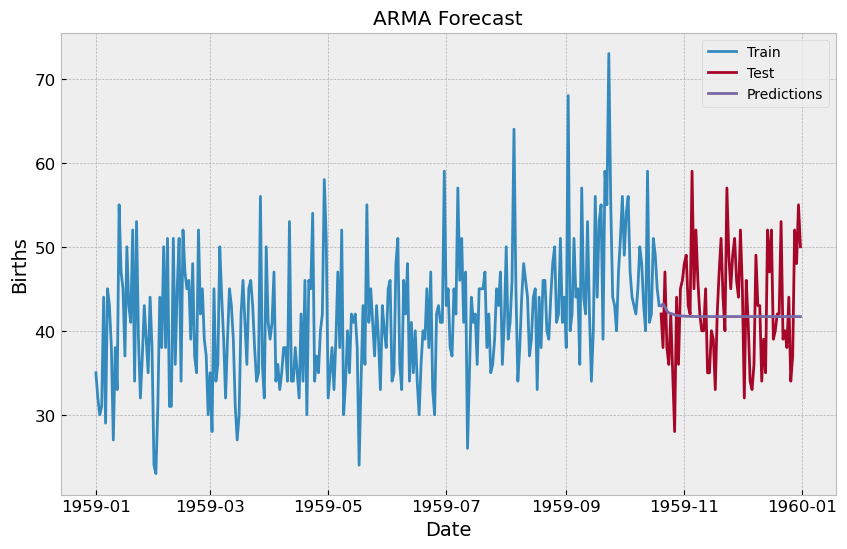

In [30]:
import matplotlib.pyplot as plt
from pmdarima import ARIMA
from statsmodels.tools.eval_measures import rmse

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url)

# Convert the 'Date' column to a datetime object and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Create an ARMA model and fit it to the training data
order = (5, 0, 0)  # Order of the ARMA model: (p, d, q) = (5, 0, 0)
model = ARIMA(order=order, suppress_warnings=True)
model_fit = model.fit(train['Births'])

# Make predictions on the test set
predictions = model_fit.predict(n_periods=len(test))

# Calculate RMSE
error = rmse(test['Births'], predictions)
print(f"Root Mean Squared Error (RMSE): {error:.2f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Births'], label='Train')
plt.plot(test.index, test['Births'], label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.title("ARMA Forecast")
plt.xlabel('Date')
plt.ylabel('Births')
plt.show()

Root Mean Squared Error (RMSE): 6.84


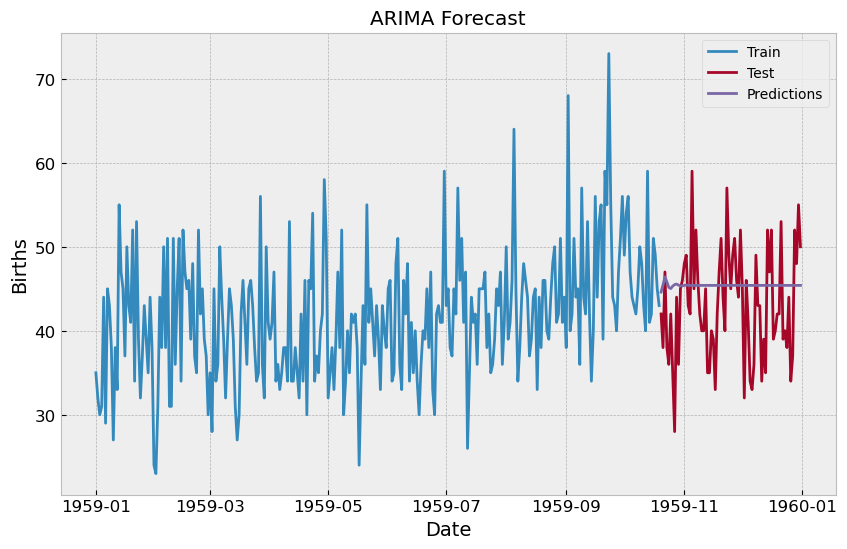

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url)

# Convert the 'Date' column to a datetime object and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Create an ARIMA model and fit it to the training data
order = (5, 1, 0)  # Order of the ARIMA model: (p, d, q) = (5, 1, 0)
model = ARIMA(train['Births'], order=order)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calculate RMSE
error = rmse(test['Births'], predictions)
print(f"Root Mean Squared Error (RMSE): {error:.2f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Births'], label='Train')
plt.plot(test.index, test['Births'], label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.title("ARIMA Forecast")
plt.xlabel('Date')
plt.ylabel('Births')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1978.958, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2140.816, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2071.359, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1974.613, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2138.818, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1974.959, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1975.012, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1976.941, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1975.608, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.824 seconds
Root Mean Squared Error (RMSE): 8.54


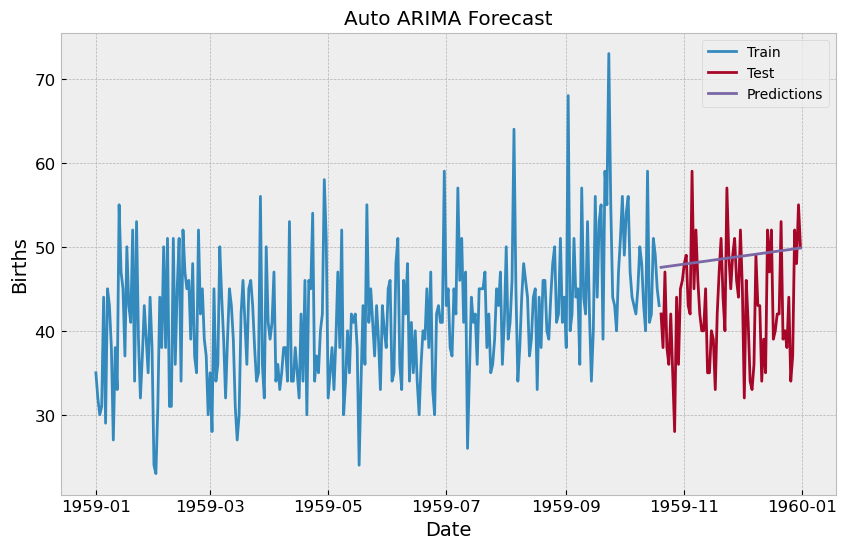

In [31]:
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url)

# Convert the 'Date' column to a datetime object and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Perform auto_arima to determine the best parameters
autoModel = auto_arima(train['Births'], seasonal=False, trace=True,
                       error_action='ignore', suppress_warnings=True)

# Fit the ARIMA model with the determined parameters to the training data
autoModel.fit(train['Births'])

# Make predictions on the test set
predictions = autoModel.predict(n_periods=len(test))

# Calculate RMSE
error = rmse(test['Births'], predictions)
print(f"Root Mean Squared Error (RMSE): {error:.2f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Births'], label='Train')
plt.plot(test.index, test['Births'], label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.title("Auto ARIMA Forecast")
plt.xlabel('Date')
plt.ylabel('Births')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1980.241, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2140.816, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2071.507, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1973.405, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2138.818, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1974.613, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1975.345, Time=0.25 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1975.275, Time=0.75 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1973.346, Time=0.19 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1975.344, Time=0.43 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=1977.346, Time=0.61 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2141.865, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1974.254, Time=0.25 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=1974.275, Time=0.27 sec
 ARIMA(1,1,2)(1,0,0

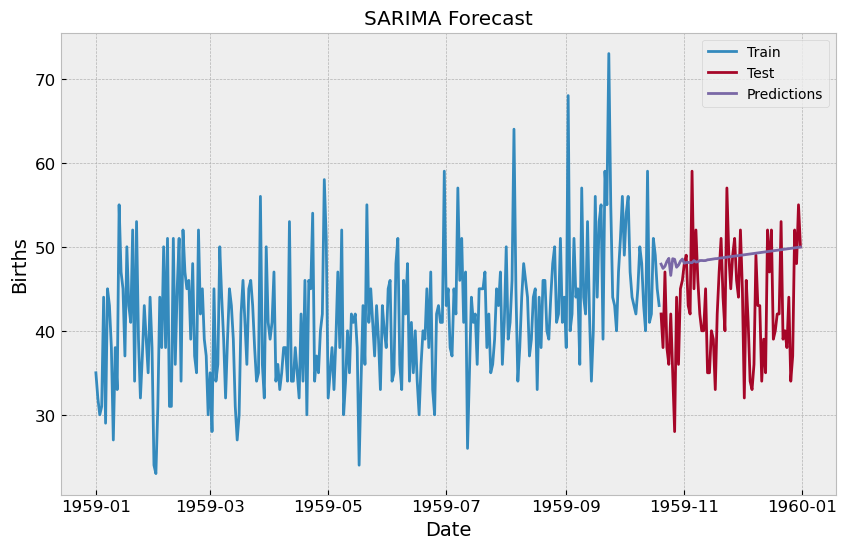

In [32]:
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url)

# Convert the 'Date' column to a datetime object and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Perform auto_arima to determine the best parameters
autoModel = auto_arima(train['Births'], seasonal=True, m=12, trace=True,
                       error_action='ignore', suppress_warnings=True)

# Fit the SARIMA model with the determined parameters to the training data
autoModel.fit(train['Births'])

# Make predictions on the test set
predictions = autoModel.predict(n_periods=len(test))

# Calculate RMSE
error = rmse(test['Births'], predictions)
print(f"Root Mean Squared Error (RMSE): {error:.2f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Births'], label='Train')
plt.plot(test.index, test['Births'], label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.title("SARIMA Forecast")
plt.xlabel('Date')
plt.ylabel('Births')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1980.241, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2140.816, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2071.507, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1973.405, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2138.818, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1974.613, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1975.345, Time=0.23 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1975.275, Time=0.72 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1973.346, Time=0.17 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1975.344, Time=0.45 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=1977.346, Time=0.59 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2141.865, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1974.254, Time=0.26 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=1974.275, Time=0.25 sec
 ARIMA(1,1,2)(1,0,0

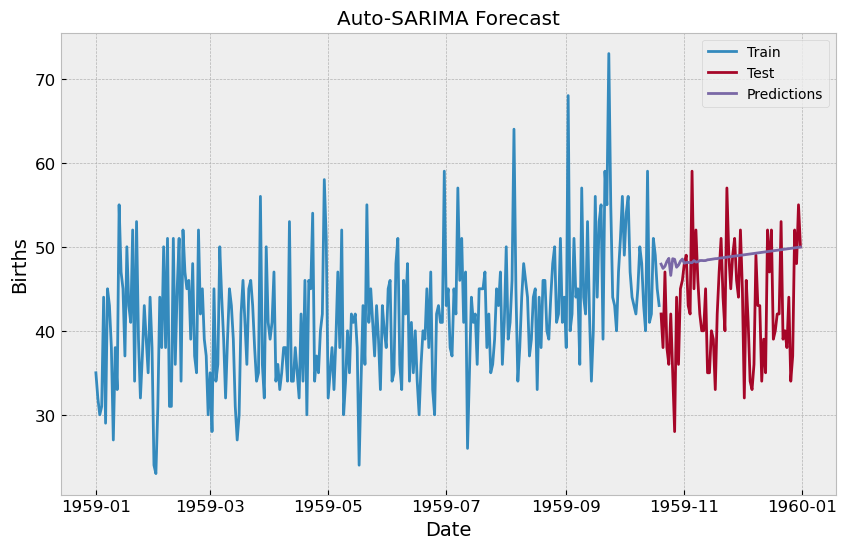

In [33]:
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url)

# Convert the 'Date' column to a datetime object and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Perform auto_arima to determine the best parameters
autoModel = auto_arima(train['Births'], seasonal=True, m=12, trace=True,
                       error_action='ignore', suppress_warnings=True)

# Fit the SARIMA model with the determined parameters to the training data
autoModel.fit(train['Births'])

# Make predictions on the test set
predictions = autoModel.predict(n_periods=len(test))

# Calculate RMSE
error = rmse(test['Births'], predictions)
print(f"Root Mean Squared Error (RMSE): {error:.2f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Births'], label='Train')
plt.plot(test.index, test['Births'], label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.title("Auto-SARIMA Forecast")
plt.xlabel('Date')
plt.ylabel('Births')
plt.show()